# Βαθιά μάθηση στο CIFAR-100

**Ομάδα**: $\;\;\;$70 <br> **Φοιτητές**: Γιαννιός Γεώργιος Ταξιάρχης 031 16 156$\;\;\;\;\;\;\;\;\;\;\;\;\;$ Μπέτζελος Γιώργος 031 17 442  $\;\;\;\;\;\;\;\;\;\;\;\;\;$ Μπέτζελος Χρήστος 031 16 067 <br>

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Συνάρτηση για υπολογισμό memory usage με βαση τις παραμέτρους (για μια εικόνα)

#Πήγη 
#https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [ ]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [ ]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [ ]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με ένα μοναδικό ξεχωριστό υποσύνολο του CIFAR-100
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό της ομάδας σας.

In [ ]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 70

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [ ]:
# select the number of classes
cifar100_classes_url = select_classes_number(classes_number = 40)

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [ ]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [ ]:
# print our classes
print(our_classes)

['apple', ' baby', ' bear', ' beaver', ' bus', ' cattle', ' clock', ' cockroach', ' crab', ' crocodile', ' dinosaur', ' dolphin', ' hamster', ' house', ' kangaroo', ' lamp', ' leopard', ' lion', ' lobster', ' man', ' mountain', ' orchid', ' pear', ' pickup_truck', ' pine_tree', ' plain', ' porcupine', ' possum', ' rose', ' skunk', ' skyscraper', ' squirrel', ' streetcar', ' tank', ' telephone', ' tiger', ' trout', ' wardrobe', ' wolf', ' worm']


In [ ]:
CLASSES_NUM=len(our_classes)

In [ ]:
print(x_train_ds[1].shape)

(32, 32, 3)


3000
Train: X=(17000, 32, 32, 3), y=(17000, 1)
Validation: X=(3000, 32, 32, 3), y=(3000, 1)
Test: X=(4000, 32, 32, 3), y=(4000, 1)


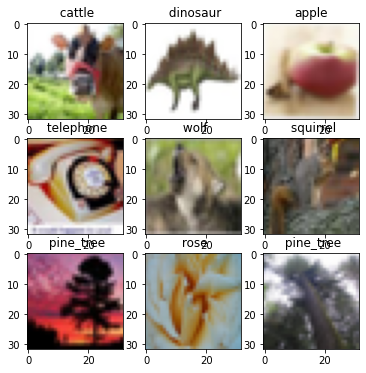

In [ ]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [ ]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def _input_fn_ds(ds, BATCH_SIZE):
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1, image_size=32,callback = None):
  
  if image_size == 32:
    train_ds = train_ds_32
    validation_ds = validation_ds_32

  elif image_size == 78:
    train_ds = train_ds_78
    validation_ds = validation_ds_78
  
  elif image_size == 96:
    train_ds = train_ds_96
    validation_ds = validation_ds_96

  elif image_size == 128:
    train_ds = train_ds_128
    validation_ds = validation_ds_128
  
  if (callback == None):
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  else:
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps,callbacks=[callback])

  return (history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps, image_size):
  if image_size==32:
    test_ds = test_ds_32
  elif image_size==78:
    test_ds = test_ds_78
  elif image_size==96:
    test_ds = test_ds_96
  elif image_size==128:
    test_ds = test_ds_128
  
  print('\nTest set evaluation metrics')
  loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
  print("loss: {:.2f}".format(loss0))
  print("accuracy: {:.2f}".format(accuracy0))


def model_report(model, history, evaluation_steps = 10, image_size=32):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps, image_size)

## Διαχείριση μνήμης (TFRecord)

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(image, label, shape):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'image': _bytes_feature(image),
      'label': _int64_feature(label),
      'height': _int64_feature(shape[0]),
      'width': _int64_feature(shape[1]),
      'depth': _int64_feature(shape[2]),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
def write_tf_records(tfrecord_dir, x, y):
  with tf.io.TFRecordWriter(tfrecord_dir) as writer:
    for image, label in zip(x, y):
                
      image = tf.image.resize(image, (TARGET_SIZE[0], TARGET_SIZE[1]))
          
      img_bytes = tf.io.serialize_tensor(image)
      shape = image.shape
          
      example = serialize_example(img_bytes, label, shape)
      writer.write(example)
  return None

In [ ]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),  
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  example = tf.io.parse_single_example(example_proto, image_feature_description)
  label = example["label"]
  image_shape = TARGET_SIZE

  image = tf.io.parse_tensor(example["image"], float)
  image = tf.reshape(image, image_shape)

  return  image , [label]

In [ ]:
def read_dataset(file):
  dataset = tf.data.TFRecordDataset(file)
  return dataset.map(_parse_image_function)

### Μέγεθος εικόνας (32x32)

In [ ]:
train_ds_32 =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds_32 =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds_32 =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

### Μέγεθος εικόνας (78x78)

In [ ]:
TARGET_SIZE = (78,78,3)

if not os.path.exists('./tf_records_78'):
  os.makedirs('./tf_records_78')

write_tf_records("./tf_records_78/" + "train.tfrecords", x_train, y_train)
write_tf_records("./tf_records_78/" + "validation.tfrecords", x_val, y_val)
write_tf_records("./tf_records_78/" + "test.tfrecords", x_test, y_test)

In [ ]:
train_ds_78 = read_dataset("./tf_records_78/" + "train.tfrecords")
validation_ds_78 = read_dataset("./tf_records_78/" + "validation.tfrecords")
test_ds_78 = read_dataset("./tf_records_78/" + "test.tfrecords")

In [ ]:
train_ds_78 = _input_fn_ds(train_ds_78, BATCH_SIZE)
validation_ds_78 = _input_fn_ds(validation_ds_78, BATCH_SIZE)
test_ds_78 = _input_fn_ds(test_ds_78, BATCH_SIZE)

### Μέγεθος εικόνας (96x96)

In [ ]:
TARGET_SIZE = (96,96,3)

if not os.path.exists('./tf_records_96'):
  os.makedirs('./tf_records_96')

write_tf_records("./tf_records_96/" + "train.tfrecords", x_train, y_train)
write_tf_records("./tf_records_96/" + "validation.tfrecords", x_val, y_val)
write_tf_records("./tf_records_96/" + "test.tfrecords", x_test, y_test)

In [ ]:
train_ds_96 = read_dataset("./tf_records_96/" + "train.tfrecords")
validation_ds_96 = read_dataset("./tf_records_96/" + "validation.tfrecords")
test_ds_96 = read_dataset("./tf_records_96/" + "test.tfrecords")

In [ ]:
train_ds_96 = _input_fn_ds(train_ds_96, BATCH_SIZE)
validation_ds_96 = _input_fn_ds(validation_ds_96, BATCH_SIZE)
test_ds_96 = _input_fn_ds(test_ds_96, BATCH_SIZE)

### Μέγεθος εικόνας (128x128)

In [ ]:
TARGET_SIZE = (128,128,3)

if not os.path.exists('./tf_records_128'):
  os.makedirs('./tf_records_128')

write_tf_records("./tf_records_128/" + "train.tfrecords", x_train, y_train)
write_tf_records("./tf_records_128/" + "validation.tfrecords", x_val, y_val)
write_tf_records("./tf_records_128/" + "test.tfrecords", x_test, y_test)

In [ ]:
train_ds_128 = read_dataset("./tf_records_128/" + "train.tfrecords")
validation_ds_128 = read_dataset("./tf_records_128/" + "validation.tfrecords")
test_ds_128 = read_dataset("./tf_records_128/" + "test.tfrecords")

In [ ]:
train_ds_128 = _input_fn_ds(train_ds_128, BATCH_SIZE)
validation_ds_128 = _input_fn_ds(validation_ds_128, BATCH_SIZE)
test_ds_128 = _input_fn_ds(test_ds_128, BATCH_SIZE)

## Δοκιμές διαφορετικών μοντέλων

Δοκιμάζουμε μοντέλα "**from scratch**", όπου ορίζουμε την αρχιτεκτονική του δικτύου όπως θέλουμε, και επίσης δοκιμάζουμε μοντέλα χρησιμοποιώντας **μεταφορά μάθησης**.


### Μοντέλα "from scratch"

#### Μοντέλο 1: CNN (Μικρό Συνελικτικό Δίκτυο)

In [ ]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

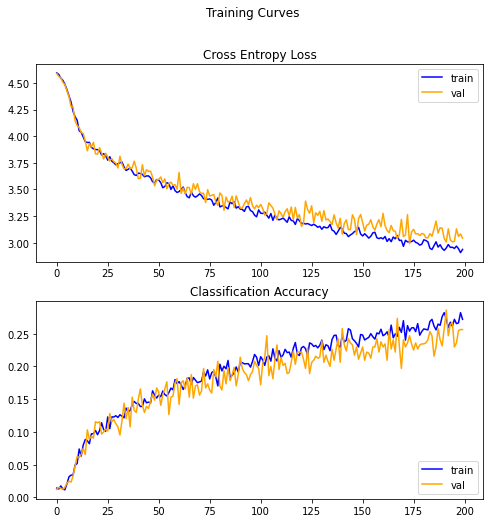


Test set evaluation metrics
30/30 [==============================] - 0s 5ms/step - loss: 3.0227 - accuracy: 0.2560
loss: 3.02
accuracy: 0.26


In [ ]:
SIMPLE_MODEL = init_simple_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, SIMPLE_MODEL)*1024,"MB")
print("")

start_time = time.time()
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 200, 30, 5)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

#### Μοντέλο 2: CNN Custom

In [ ]:
def init_model_2(summary):
  model_2 = models.Sequential()

  model_2.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=(32, 32, 3),padding = 'same'))
  model_2.add(layers.AveragePooling2D((2, 2),padding = 'same'))

  model_2.add(layers.Conv2D(16, (3, 3), activation='relu',padding = 'same'))
  model_2.add(layers.AveragePooling2D((2, 2),padding = 'same'))

  model_2.add(layers.Conv2D(32, (2, 2), activation='relu',padding = 'same'))
  model_2.add(layers.Flatten())

  model_2.add(layers.Dense(1024, activation='relu'))
  model_2.add(layers.Dense(200, activation='relu'))
  model_2.add(layers.Dense(100, activation='softmax'))

  model_2.compile(optimizer=tf.optimizers.Adamax(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model_2.summary()
  return model_2

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        3488      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 32)          2080      
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)             

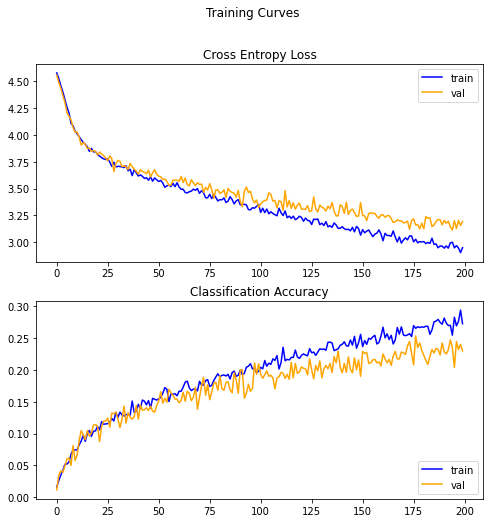


Test set evaluation metrics
30/30 [==============================] - 0s 4ms/step - loss: 3.1447 - accuracy: 0.2471
loss: 3.14
accuracy: 0.25


In [ ]:
MODEL_2 = init_model_2(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, MODEL_2)*1024,"MB")
print("")

start_time = time.time()
MODEL_2_history = train_model(MODEL_2, 200, 30, 10)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")
model_report(MODEL_2, MODEL_2_history, 30)

#### Μοντέλο 3: LeNet

In [ ]:
def init_lenet(summary):
  lenet = models.Sequential()
  lenet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  lenet.add(layers.MaxPooling2D((2, 2)))
  lenet.add(layers.Conv2D(32, (3, 3), activation='relu'))
  lenet.add(layers.MaxPooling2D((2, 2)))

  lenet.add(layers.Flatten())

  lenet.add(layers.Dense(512, activation='relu'))
  lenet.add(layers.Dense(200, activation='relu'))
  lenet.add(layers.Dense(100, activation='softmax'))

  lenet.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    lenet.summary()
  return lenet

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               590336    
_________________________________________________________________
dense_12 (Dense)             (None, 200)              

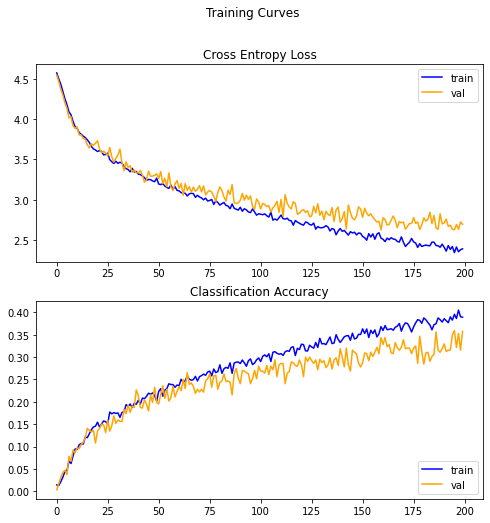


Test set evaluation metrics
30/30 [==============================] - 0s 4ms/step - loss: 2.6686 - accuracy: 0.3286
loss: 2.67
accuracy: 0.33


In [ ]:
LENET = init_lenet(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, LENET)*1024,"MB")
print("")

start_time = time.time()
LENET_history = train_model(LENET, 200, 30, 5)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(LENET, LENET_history, 30)

### Μεταφορά μάθησης

Χρησιμοποιούμε τη [μεταφορά μάθησης του tf2](https://www.tensorflow.org/tutorials/images/transfer_learning). Σε αντίθεση με τα μοντέλα "from scratch" η μεταφορά μάθησης μας επιστρέφει έτοιμα μοντέλα με προκαθορισμένη αρχιτεκτονική στην οποία μπορούμε γενικά μόνο να προσθέσουμε επίπεδα, τα οποία περιορίζονται σε πλήρως διασυνδεδεμένα επίπεδα που εξειδικεύονται στο συγκεκριμένο task ταξινόμησης που έχουμε να επιτελέσουμε.

#### Μοντέλο 1: VGG16

In [ ]:
def init_VGG16_model(summary):
  vgg_model=tf.keras.applications.VGG16(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  VGG16_MODEL=vgg_model.layers[0](vgg_model)

  # unfreeze conv layers
  VGG16_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Memory usage according to parameters: 58.368 MB

Epoch 1/50
40/40 [==============================] - 106s 654ms/step - loss: 4.7029 - accuracy: 0.0147 - val_loss: 4.1370 - val_accuracy: 0.0805
Epoch 2/50
40/40 [============================

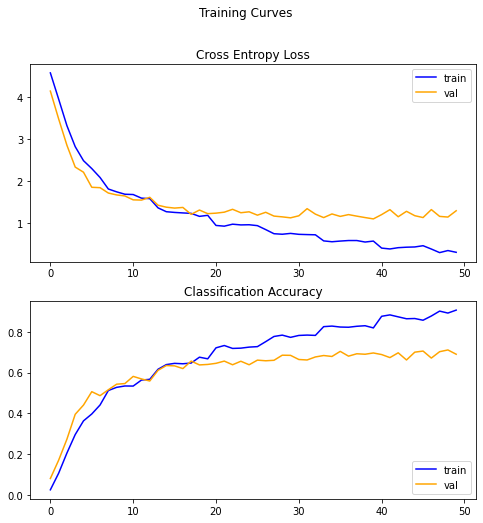


Test set evaluation metrics
30/30 [==============================] - 21s 70ms/step - loss: 1.1951 - accuracy: 0.7008
loss: 1.20
accuracy: 0.70


In [ ]:
VGG16_MODEL = init_VGG16_model(True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, VGG16_MODEL)*1024,"MB")
print("")

start_time = time.time()
VGG16_MODEL_history = train_model(VGG16_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(VGG16_MODEL, VGG16_MODEL_history, 30, 78)

#### Μοντέλο 2: Xception

In [ ]:
def init_XCEPTION_model(summary):
  xception_model=tf.keras.applications.Xception(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  XCEPTION_MODEL=xception_model.layers[0](xception_model)

  # unfreeze conv layers
  XCEPTION_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  batch_layer = tf.keras.layers.BatchNormalization()
  dense_layer = tf.keras.layers.Dense(256, activation='relu')

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([XCEPTION_MODEL, dropout_layer, batch_layer, global_average_layer, dense_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_26 (Dense)             (None, 100)               25700     
Total params: 21,419,916
Trainable params: 21,361,292


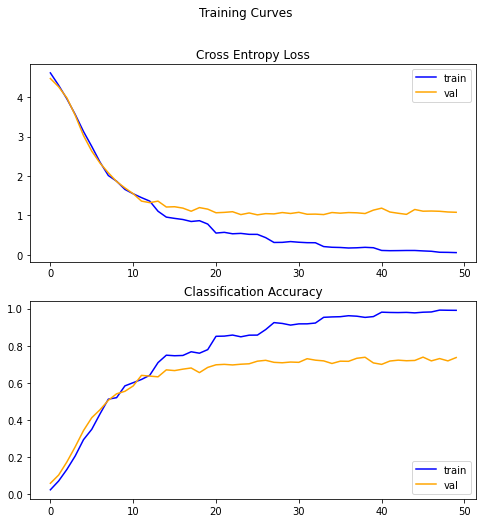


Test set evaluation metrics
30/30 [==============================] - 21s 67ms/step - loss: 1.0386 - accuracy: 0.7417
loss: 1.04
accuracy: 0.74


In [ ]:
XCEPTION_MODEL = init_XCEPTION_model(True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, XCEPTION_MODEL)*1024,"MB")
print("")

start_time = time.time()
XCEPTION_MODEL_history = train_model(XCEPTION_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(XCEPTION_MODEL, XCEPTION_MODEL_history, 30, 78)

#### Μοντέλο 3: EfficientNetB7

In [ ]:
def init_EFFICIENT_B7_model(summary):
  efficient_b7_model=tf.keras.applications.EfficientNetB7(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  EFFICIENT_B7_MODEL=efficient_b7_model.layers[0](efficient_b7_model)

  # unfreeze conv layers
  EFFICIENT_B7_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([EFFICIENT_B7_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 3, 3, 2560)        64097687  
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 2560)        0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2560)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               256100    
Total params: 64,353,787
Trainable params: 64,043,060
Non-trainable params: 310,727
_________________________________________________________________
Memory usage according to parameters: 269.312 MB

Epoch 1/50
40/40 [==============================] - 155s 2s/step - loss: 4.6720 - accuracy: 0.0127 - val_loss: 4.7815 - val_accuracy: 0.0141
Epoch 2/50
40/40 [========================

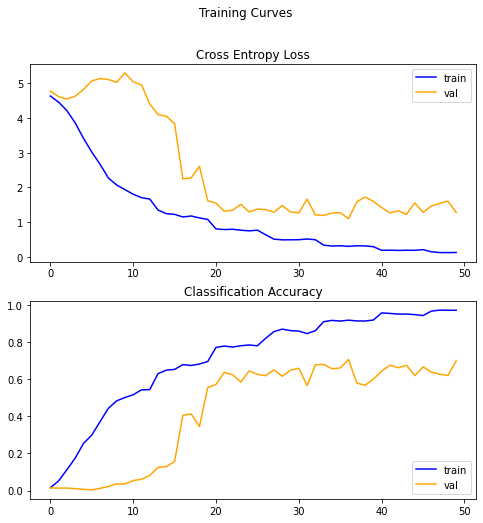


Test set evaluation metrics
30/30 [==============================] - 27s 238ms/step - loss: 1.2108 - accuracy: 0.6953
loss: 1.21
accuracy: 0.70


In [ ]:
EFFICIENT_B7_MODEL = init_EFFICIENT_B7_model(True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, EFFICIENT_B7_MODEL)*1024,"MB")
print("")

start_time = time.time()
EFFICIENT_B7_MODEL_history = train_model(EFFICIENT_B7_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(EFFICIENT_B7_MODEL, EFFICIENT_B7_MODEL_history, 30, 78)

#### Μοντέλο 4: ResNet50

In [ ]:
def init_RESNET50_model(summary):
  resnet50_model=tf.keras.applications.ResNet50(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  RESNET50_MODEL=resnet50_model.layers[0](resnet50_model)

  # unfreeze conv layers
  RESNET50_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([RESNET50_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
Total params: 23,792,612
Trainable params: 23,739,492
Non-trainable params: 53,120
_________________________________________________________________
Memory usage according to parameters: 109.568 MB

Epoch 1/50
40/40 [==============================] - 58s 685ms/step - loss: 5.3894 - accuracy: 0.0227 - val_loss: 6.0514 - 

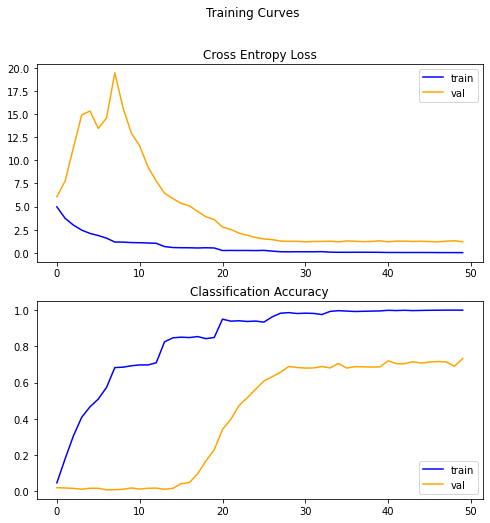


Test set evaluation metrics
30/30 [==============================] - 21s 59ms/step - loss: 1.2152 - accuracy: 0.7063
loss: 1.22
accuracy: 0.71


In [ ]:
RESNET50_MODEL = init_RESNET50_model(True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, RESNET50_MODEL)*1024,"MB")
print("")

start_time = time.time()
RESNET50_MODEL_history = train_model(RESNET50_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(RESNET50_MODEL, RESNET50_MODEL_history, 30, 78)

#### Μοντέλο 5: ResNet152V2

In [ ]:
def init_RESNET152_model(summary):
  resnet152_model=tf.keras.applications.ResNet152V2(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  RESNET152_MODEL=resnet152_model.layers[0](resnet152_model)

  # unfreeze conv layers
  RESNET152_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([RESNET152_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

234553344/234545216 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 3, 3, 2048)        58331648  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
Total params: 58,536,548
Trainable params: 58,392,804
Non-trainable params: 143,744
_________________________________________________________________
Memory usage according to parameters: 242.688 MB

Epoch 1/50
40/40 [==============================] - 47s 623ms/step - loss: 5.0991 - accuracy: 0.0210 - val_loss: 4.76

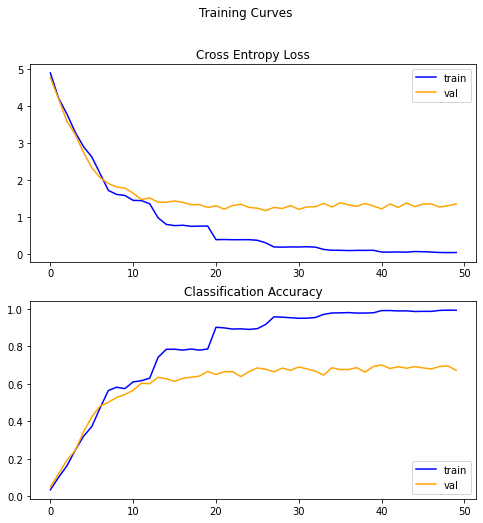


Test set evaluation metrics
30/30 [==============================] - 9s 143ms/step - loss: 1.3113 - accuracy: 0.6924
loss: 1.31
accuracy: 0.69


In [ ]:
RESNET152_MODEL = init_RESNET152_model(True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, RESNET152_MODEL)*1024,"MB")
print("")

start_time = time.time()
RESNET152_MODEL_history = train_model(RESNET152_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(RESNET152_MODEL, RESNET152_MODEL_history, 30, 78)

#### Μοντέλο 6: DenseNet121

In [ ]:
def init_DENSE121_model(summary):
  dense121_model=tf.keras.applications.DenseNet121(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  DENSE121_MODEL=dense121_model.layers[0](dense121_model)

  # unfreeze conv layers
  DENSE121_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([DENSE121_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 1024)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               102500    
Total params: 7,140,004
Trainable params: 7,056,356
Non-trainable params: 83,648
_________________________________________________________________
Memory usage according to parameters: 31.744 MB

Epoch 1/50
40/40 [==============================] - 31s 348ms/step - loss: 5.8739 - accuracy: 0.0153 - val_loss: 4.7131 - val_accuracy: 0.0430
Epoch 2/50
40/40 [===========================

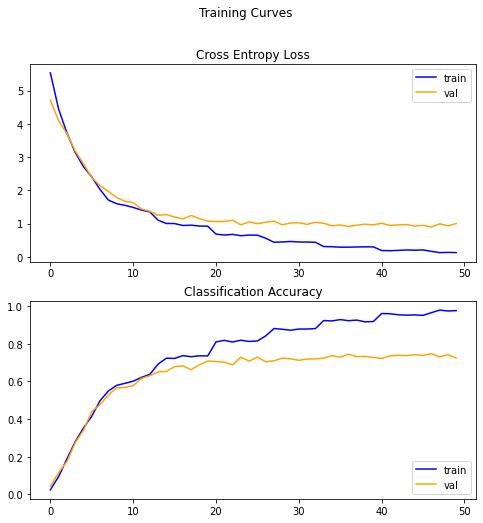


Test set evaluation metrics
30/30 [==============================] - 21s 56ms/step - loss: 0.9297 - accuracy: 0.7398
loss: 0.93
accuracy: 0.74


In [ ]:
DENSE121_MODEL = init_DENSE121_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE121_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE121_MODEL_history = train_model(DENSE121_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE121_MODEL, DENSE121_MODEL_history, 30,78)

#### Μοντέλο 7: DenseNet169

In [ ]:
def init_DENSE169_model(summary, inp_size=78):
  dense169_model=tf.keras.applications.DenseNet169(input_shape=(inp_size,inp_size,3), include_top=False, weights='imagenet')
  
  DENSE169_MODEL=dense169_model.layers[0](dense169_model)

  # unfreeze conv layers
  DENSE169_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([DENSE169_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 2, 2, 1664)        12642880  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1664)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               166500    
Total params: 12,809,380
Trainable params: 12,650,980
Non-trainable params: 158,400
_________________________________________________________________
Memory usage according to parameters: 56.32 MB

Epoch 1/50
40/40 [==============================] - 38s 397ms/step - loss: 5.4100 - accuracy: 0.0186 - val_loss: 5.4097 -

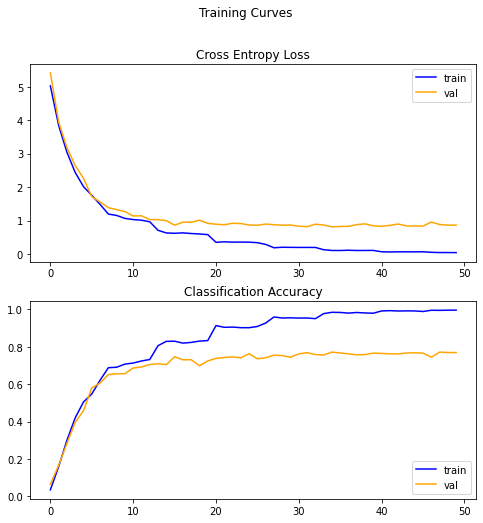


Test set evaluation metrics
30/30 [==============================] - 21s 68ms/step - loss: 0.8682 - accuracy: 0.7659
loss: 0.87
accuracy: 0.77


In [ ]:
DENSE169_MODEL = init_DENSE169_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE169_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE169_MODEL_history = train_model(DENSE169_MODEL, 50, 40, 10,78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE169_MODEL, DENSE169_MODEL_history, 30,78)

#### Μοντέλο 8: DenseNet201

In [ ]:
def init_DENSE201_model(summary, inp_size=78, data_augment=False, train="All", dropout=0.5, learning_rate=0.00005, optimizer="Adam"):
  dense201_model=tf.keras.applications.DenseNet201(input_shape=(inp_size,inp_size,3), include_top=False, weights='imagenet')
  
  DENSE201_MODEL=dense201_model.layers[0](dense201_model)

  # Unfreeze conv layers (Συνολικά 707 layers)
  if train=="All":
    DENSE201_MODEL.trainable=True
  elif train=="10%":
    # εκαπαιδεύουμε τα τελευταία επίπεδα 71 (10%) 
    for layer in dense201_model.layers[:636]:
      layer.trainable = False
  elif train=="20%":
    # εκαπαιδεύουμε τα τελευταία επίπεδα 142 (20%) 
    for layer in dense201_model.layers[:565]:
      layer.trainable = False
  elif train=="None":
    # Freeze the pretrained weights
    dense201_model.trainable = False
  
  
  dropout_layer = tf.keras.layers.Dropout(rate = dropout)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  
  # Data augmentation
  if data_augment:
    model = tf.keras.Sequential([data_augmentation, DENSE201_MODEL, dropout_layer, global_average_layer, prediction_layer])
  else:
    model = tf.keras.Sequential([DENSE201_MODEL, dropout_layer, global_average_layer, prediction_layer])
  
  # Optimizer
  if optimizer=="Adam":
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  elif optimizer=="Adamax":
    model.compile(optimizer=tf.optimizers.Adamax(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  elif optimizer=="SGD":
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.0005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 78.848 MB

Epoch 1/50
40/40 [==============================] - 44s 487ms/step - loss: 5.1474 - accuracy: 0.0273 - val_loss: 4.1773 

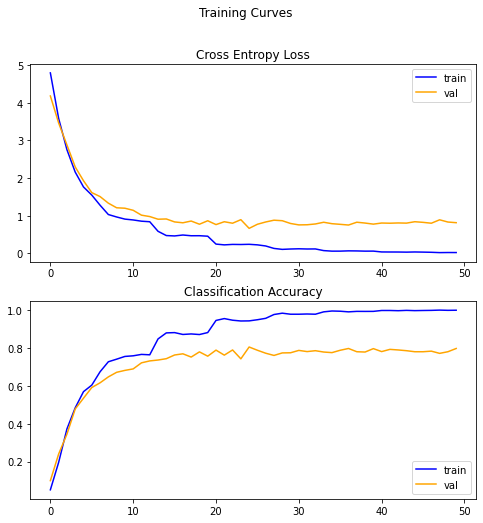


Test set evaluation metrics
30/30 [==============================] - 22s 85ms/step - loss: 0.8059 - accuracy: 0.7828
loss: 0.81
accuracy: 0.78


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 78)

#### Μοντέλο 9: ΜobileNetV2

In [ ]:
# transfer learning: Input size must be at least 75x75;

def init_MOBILE_NET_model(summary):
  mobile_net_model=tf.keras.applications.MobileNetV2(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  MOBILE_NET_MODEL=mobile_net_model.layers[0](mobile_net_model)

  # unfreeze conv layers
  MOBILE_NET_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([MOBILE_NET_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 3, 3, 1280)        2257984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               128100    
Total params: 2,386,084
Trainable params: 2,351,972
Non-trainable params: 34,112
_________________________________________________________________
Memory usage according to parameters: 21.504 MB

Epoch 1/50
40/40 [==============================] - 20s 233ms/step - loss: 5.2252 - accuracy: 0.0131 - val_loss: 5.7832 - val_accuracy: 0.0242
Epoch 2/50
40/40 [===========================

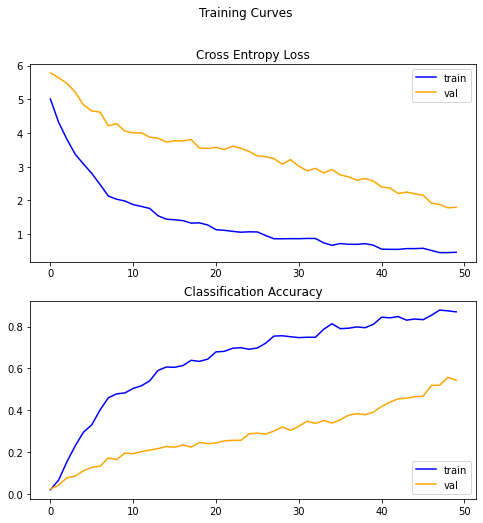


Test set evaluation metrics
30/30 [==============================] - 20s 30ms/step - loss: 1.7824 - accuracy: 0.5474
loss: 1.78
accuracy: 0.55


In [ ]:
MOBILE_NET_MODEL = init_MOBILE_NET_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, MOBILE_NET_MODEL)*1024,"MB")
print("")

start_time = time.time()
MOBILE_NET_MODEL_history = train_model(MOBILE_NET_MODEL, 50, 40, 10,78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(MOBILE_NET_MODEL, MOBILE_NET_MODEL_history, 30,78)

#### Μοντέλο 10: InceptionV3

In [ ]:
def init_INCEPTION_V3_model(summary):
  inception_v3_model=tf.keras.applications.InceptionV3(input_shape=(78,78,3), include_top=False, weights='imagenet')
  
  INCEPTION_V3_MODEL=inception_v3_model.layers[0](inception_v3_model)

  # unfreeze conv layers
  INCEPTION_V3_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([INCEPTION_V3_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               204900    
Total params: 22,007,684
Trainable params: 21,973,252
Non-trainable params: 34,432
_________________________________________________________________
Memory usage according to parameters: 87.04 MB

Epoch 1/50
40/40 [==============================] - 24s 232ms/step - loss: 4.7346 - accuracy: 0.0148 - val_loss: 4.5639 - 

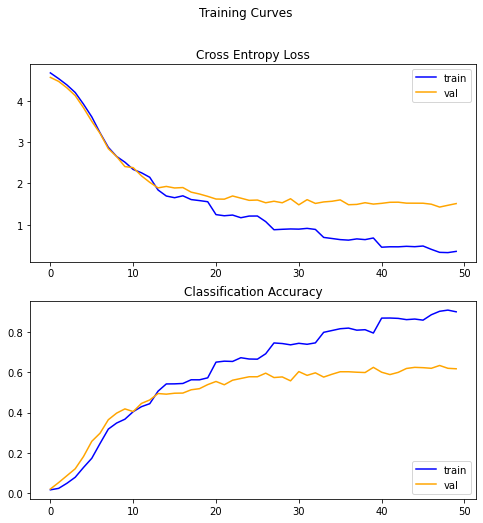


Test set evaluation metrics
30/30 [==============================] - 5s 32ms/step - loss: 1.5403 - accuracy: 0.6096
loss: 1.54
accuracy: 0.61


In [ ]:
INCEPTION_V3_MODEL = init_INCEPTION_V3_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, INCEPTION_V3_MODEL)*1024,"MB")
print("")

start_time = time.time()
INCEPTION_V3_MODEL_history = train_model(INCEPTION_V3_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(INCEPTION_V3_MODEL, INCEPTION_V3_MODEL_history, 30, 78)

## Βελτίωση της επίδοσης με πειράματα

Βελτιώνουμε τα αποτελέσματα ταξινόμησης στο CIFAR-100 και βγάζουμε συμπεράσματα, σύμφωνα με όσα ζητούνται σε σχέση με την αναφορά παράδοσης.

### Μέγεθος Εικόνας

#### Μέγεθος εικόνας (32x32)

##### DenseNet169

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1664)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               166500    
Total params: 12,809,380
Trainable params: 12,650,980
Non-trainable params: 158,400
_________________________________________________________________
Memory usage according to parameters: 51.2 MB

Epoch 1/50
40/40 [==============================] - 28s 152ms/step - loss: 5.0837 - accuracy: 0.0179 - val_loss: 4.5564 - va

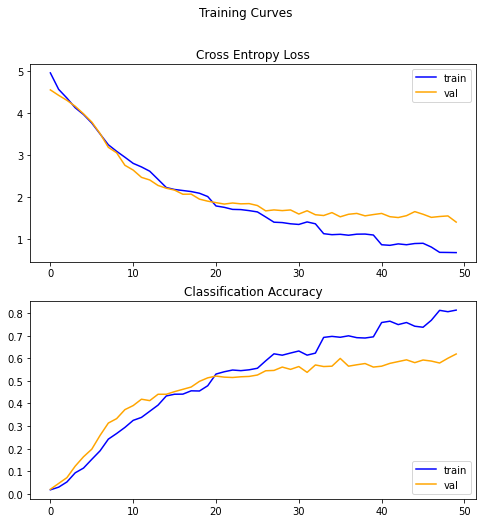


Test set evaluation metrics
30/30 [==============================] - 1s 26ms/step - loss: 1.5860 - accuracy: 0.5815
loss: 1.59
accuracy: 0.58


In [ ]:
DENSE169_MODEL = init_DENSE169_model(summary = True, inp_size=32)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE169_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE169_MODEL_history = train_model(DENSE169_MODEL, 50, 40, 10,32)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE169_MODEL, DENSE169_MODEL_history, 30,32)

##### DenseNet201

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 73.728 MB

Epoch 1/50
40/40 [==============================] - 24s 175ms/step - loss: 5.0125 - accuracy: 0.0109 - val_loss: 4.5459 - val_accuracy: 0.0227
Epoch 2/50
40/40 [========================

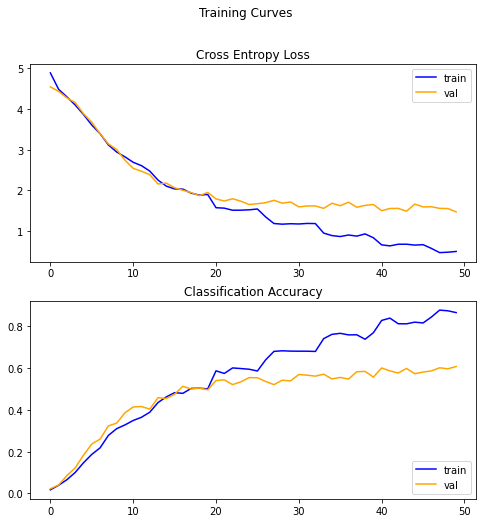


Test set evaluation metrics
30/30 [==============================] - 1s 29ms/step - loss: 1.5458 - accuracy: 0.5870
loss: 1.55
accuracy: 0.59


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=32)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30)

#### Μέγεθος εικόνας (78x78)

##### DenseNet169

51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 2, 2, 1664)        12642880  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 1664)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               166500    
Total params: 12,809,380
Trainable params: 12,650,980
Non-trainable params: 158,400
_________________________________________________________________
Memory usage according to parameters: 56.32 MB

Epoch 1/50
40/40 [==============================] - 38s 397ms/step - loss: 5.4100 - accuracy: 0.0186 - val_loss: 5.4097 -

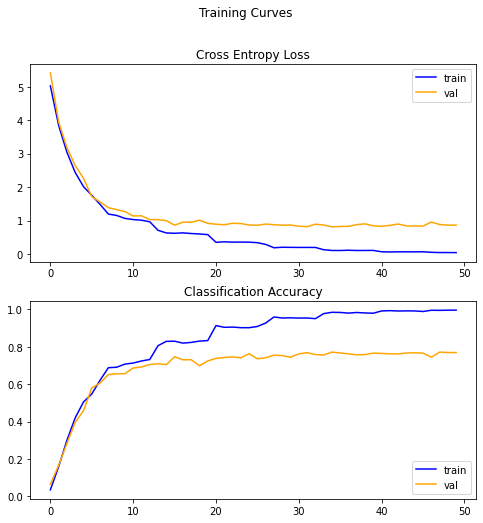


Test set evaluation metrics
30/30 [==============================] - 21s 68ms/step - loss: 0.8682 - accuracy: 0.7659
loss: 0.87
accuracy: 0.77


In [ ]:
DENSE169_MODEL = init_DENSE169_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE169_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE169_MODEL_history = train_model(DENSE169_MODEL, 50, 40, 10,78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE169_MODEL, DENSE169_MODEL_history, 30,78)

##### DenseNet201

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 78.848 MB

Epoch 1/50
40/40 [==============================] - 44s 487ms/step - loss: 5.1474 - accuracy: 0.0273 - val_loss: 4.1773 

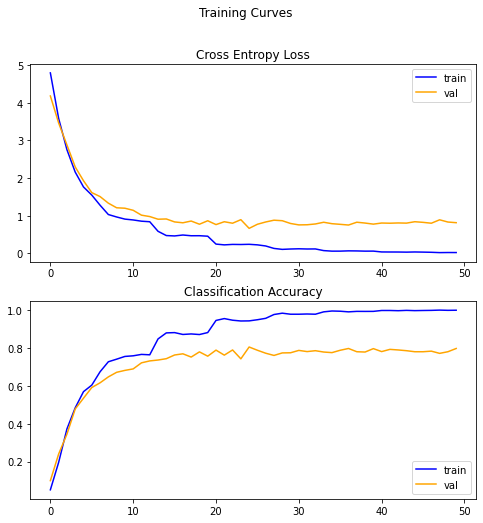


Test set evaluation metrics
30/30 [==============================] - 22s 85ms/step - loss: 0.8059 - accuracy: 0.7828
loss: 0.81
accuracy: 0.78


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 78)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 78)

#### Μέγεθος εικόνας (96x96)

##### DenseNet169

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1664)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               166500    
Total params: 12,809,380
Trainable params: 12,650,980
Non-trainable params: 158,400
_________________________________________________________________
Memory usage according to parameters: 64.512 MB

Epoch 1/50
40/40 [==============================] - 179s 1s/step - loss: 5.0202 - accuracy: 0.0278 - val_loss: 4.7290 - val_accuracy: 0.0695
Epoch 2/50
40/40 [==========================

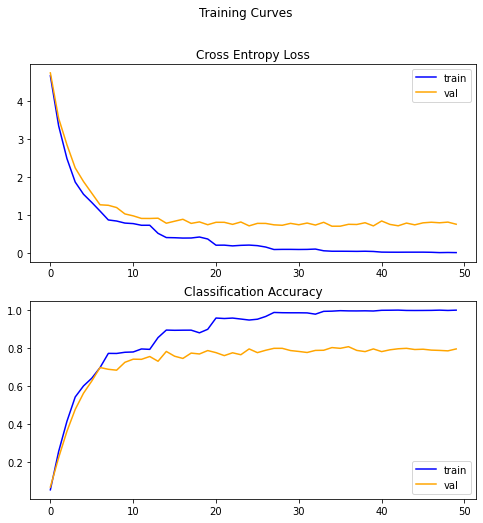


Test set evaluation metrics
30/30 [==============================] - 30s 63ms/step - loss: 0.7588 - accuracy: 0.7909
loss: 0.76
accuracy: 0.79


In [ ]:
DENSE169_MODEL = init_DENSE169_model(summary = True, inp_size=96)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE169_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE169_MODEL_history = train_model(DENSE169_MODEL, 50, 40, 10,96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE169_MODEL, DENSE169_MODEL_history, 30,96)

##### DenseNet201

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 88.064 MB

Epoch 1/50
40/40 [==============================] - 196s 1s/step - loss: 4.8427 - accuracy: 0.0401 - val_loss: 3.9665 - val_accuracy: 0.1367
Epoch 2/50
40/40 [============================

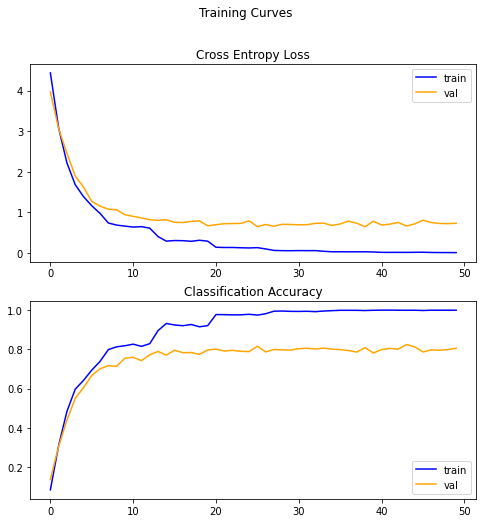


Test set evaluation metrics
30/30 [==============================] - 32s 114ms/step - loss: 0.6785 - accuracy: 0.8141
loss: 0.68
accuracy: 0.81


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(96, 96,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

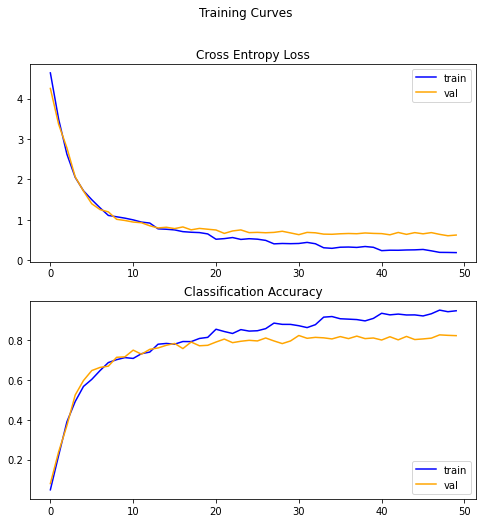


Test set evaluation metrics
30/30 [==============================] - 31s 81ms/step - loss: 0.5973 - accuracy: 0.8302
loss: 0.60
accuracy: 0.83


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### Πλήθος trainable επιπέδων

#### Freeze All

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 192,100
Non-trainable params: 18,321,984
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

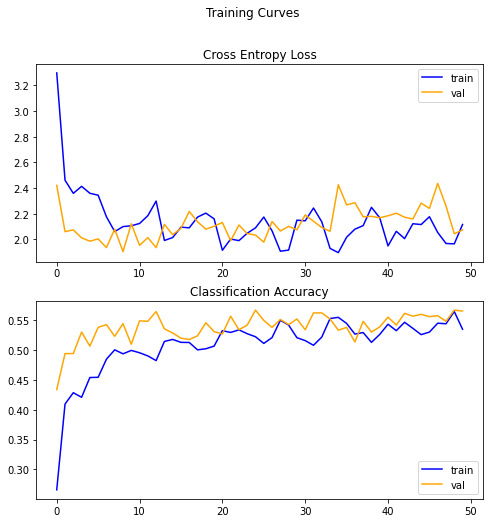


Test set evaluation metrics
30/30 [==============================] - 32s 110ms/step - loss: 2.1478 - accuracy: 0.5508
loss: 2.15
accuracy: 0.55


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, train="None")
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Unfreeze 10 %

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 2,831,140
Non-trainable params: 15,682,944
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 

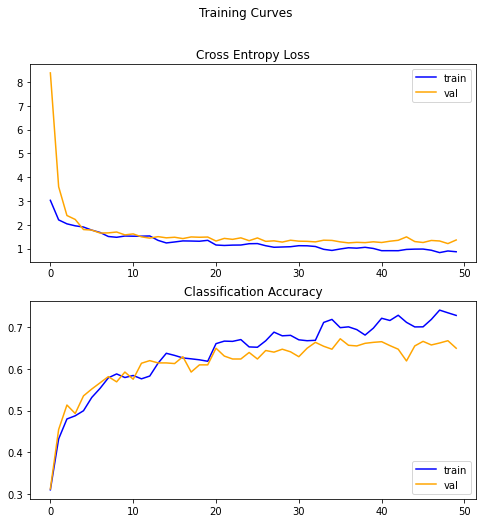


Test set evaluation metrics
30/30 [==============================] - 32s 111ms/step - loss: 1.2368 - accuracy: 0.6734
loss: 1.24
accuracy: 0.67


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, train="10%")

print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Unfreeze 20 %

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 5,056,740
Non-trainable params: 13,457,344
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 

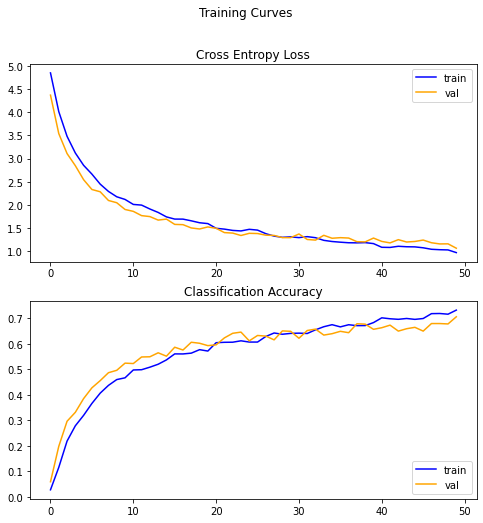


Test set evaluation metrics
30/30 [==============================] - 32s 117ms/step - loss: 1.1440 - accuracy: 0.6857
loss: 1.14
accuracy: 0.69


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, train="20%")
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Unfreeze All

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

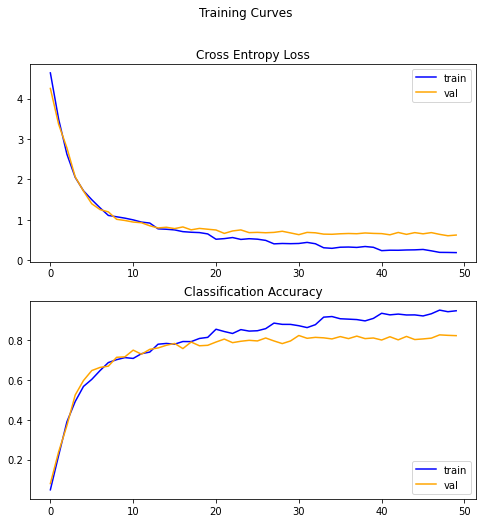


Test set evaluation metrics
30/30 [==============================] - 31s 81ms/step - loss: 0.5973 - accuracy: 0.8302
loss: 0.60
accuracy: 0.83


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### Dropout 


#### Dropout = 0.15

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 19

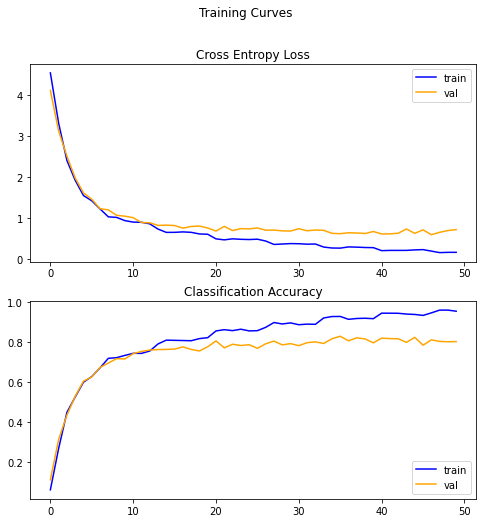


Test set evaluation metrics
30/30 [==============================] - 32s 114ms/step - loss: 0.6371 - accuracy: 0.8154
loss: 0.64
accuracy: 0.82


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, dropout=0.15)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Dropout = 0.25

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

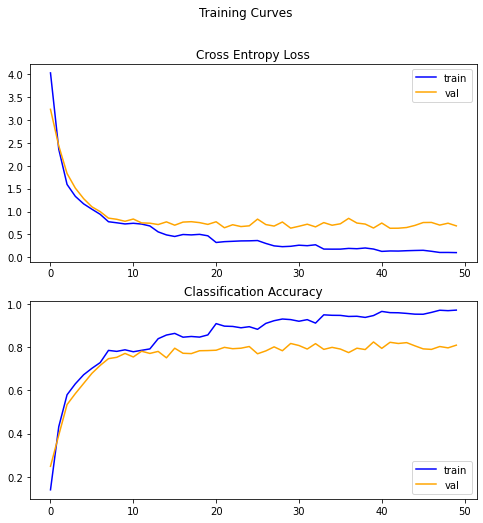


Test set evaluation metrics
30/30 [==============================] - 32s 113ms/step - loss: 0.6316 - accuracy: 0.8299
loss: 0.63
accuracy: 0.83


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, dropout=0.25)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Dropout = 0.3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 19

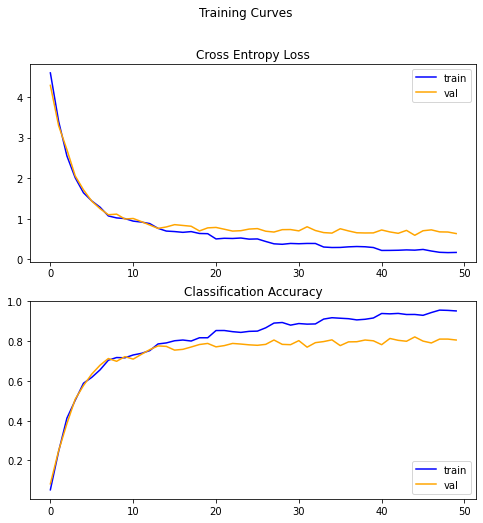


Test set evaluation metrics
30/30 [==============================] - 32s 114ms/step - loss: 0.6369 - accuracy: 0.8201
loss: 0.64
accuracy: 0.82


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, dropout=0.3)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Dropout = 0.5

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

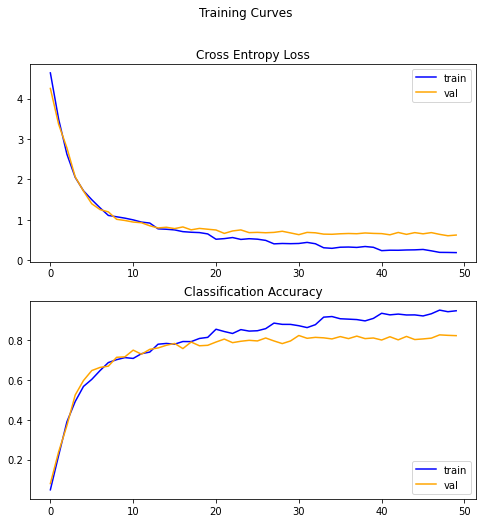


Test set evaluation metrics
30/30 [==============================] - 31s 81ms/step - loss: 0.5973 - accuracy: 0.8302
loss: 0.60
accuracy: 0.83


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Dropout = 0.7

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 18

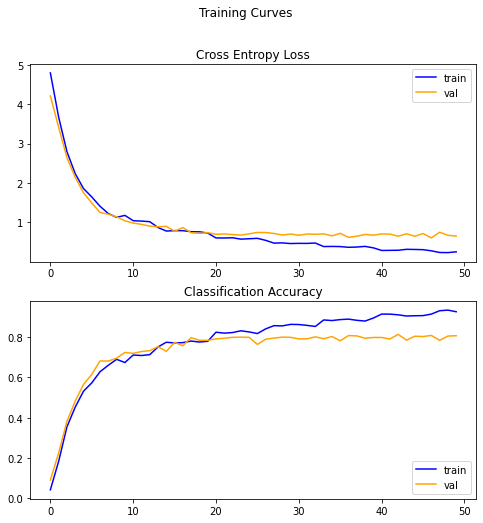


Test set evaluation metrics
30/30 [==============================] - 32s 112ms/step - loss: 0.6218 - accuracy: 0.8174
loss: 0.62
accuracy: 0.82


In [ ]:
DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, dropout=0.7)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### Early Stopping

#### patience = 3 

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

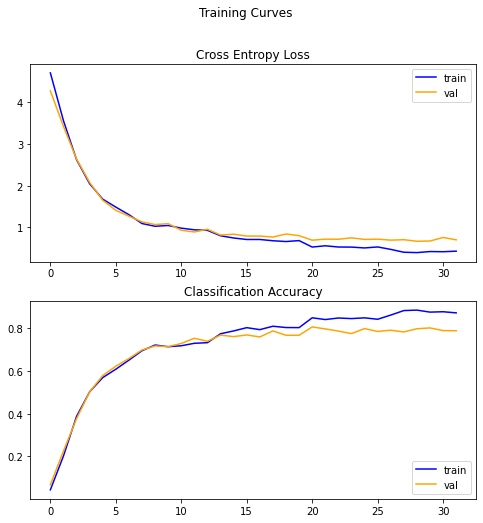


Test set evaluation metrics
30/30 [==============================] - 32s 114ms/step - loss: 0.6893 - accuracy: 0.7969
loss: 0.69
accuracy: 0.80


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### patience = 5

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

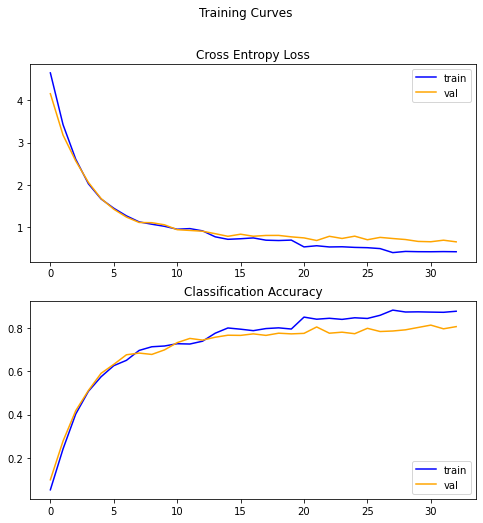


Test set evaluation metrics
30/30 [==============================] - 32s 116ms/step - loss: 0.6404 - accuracy: 0.8047
loss: 0.64
accuracy: 0.80


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### patience = 8

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

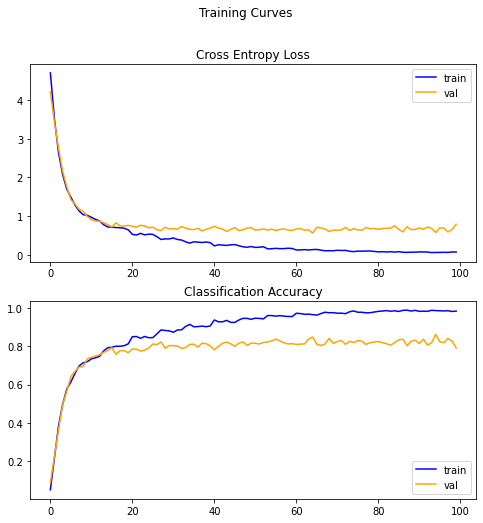


Test set evaluation metrics
30/30 [==============================] - 32s 115ms/step - loss: 0.6857 - accuracy: 0.8159
loss: 0.69
accuracy: 0.82


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### patience = 10

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

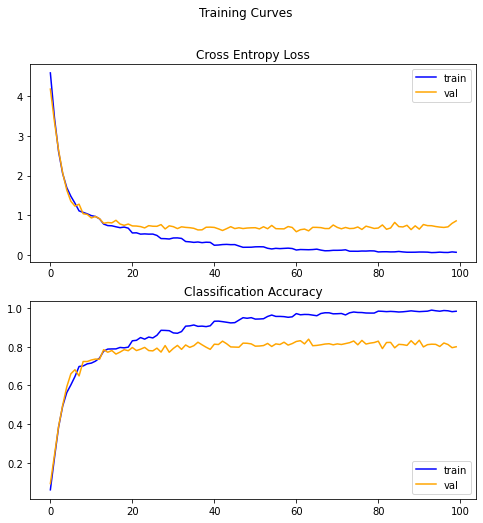


Test set evaluation metrics
30/30 [==============================] - 32s 114ms/step - loss: 0.6933 - accuracy: 0.8237
loss: 0.69
accuracy: 0.82


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


### Ρυθμός Μάθησης

#### learning_rate = $5 * 10^{-6}$

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

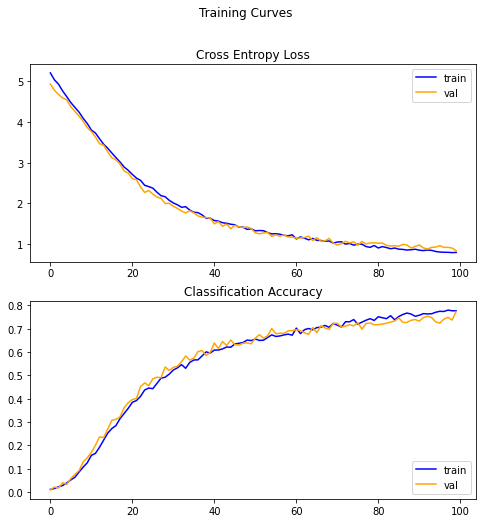


Test set evaluation metrics
30/30 [==============================] - 31s 80ms/step - loss: 0.8343 - accuracy: 0.7604
loss: 0.83
accuracy: 0.76


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000005)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### learning_rate = $10^{-5}$

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

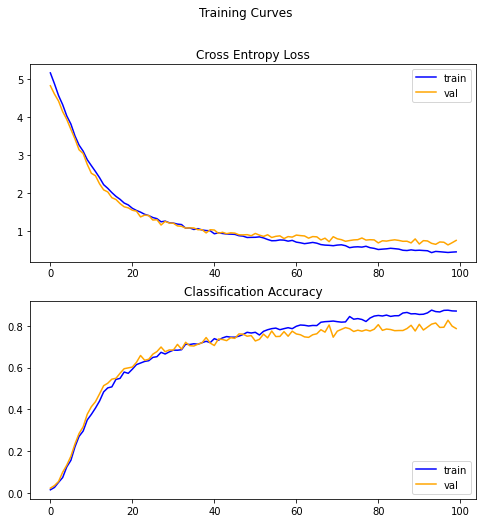


Test set evaluation metrics
30/30 [==============================] - 31s 80ms/step - loss: 0.6940 - accuracy: 0.7888
loss: 0.69
accuracy: 0.79


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.00001)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### learning_rate = $2.5 * 10^{-5}$

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

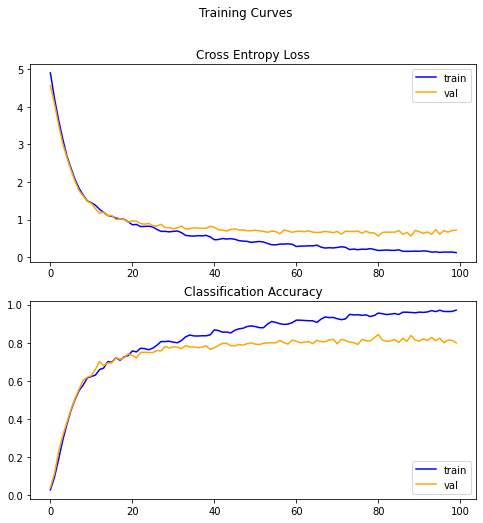


Test set evaluation metrics
30/30 [==============================] - 32s 115ms/step - loss: 0.6164 - accuracy: 0.8281
loss: 0.62
accuracy: 0.83


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


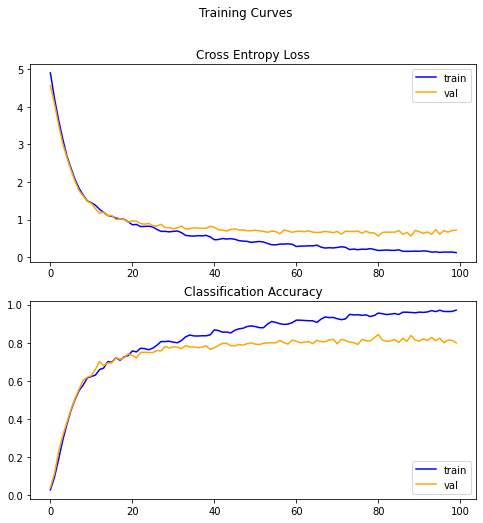


Test set evaluation metrics
30/30 [==============================] - 9s 117ms/step - loss: 0.5721 - accuracy: 0.8385
loss: 0.57
accuracy: 0.84


In [ ]:
model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### learning_rate = $5 * 10^{-5}$

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

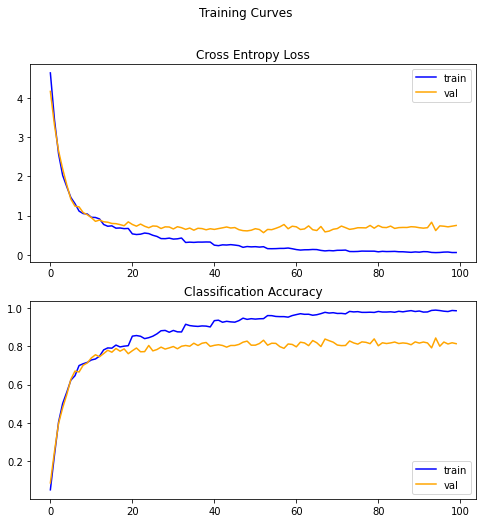


Test set evaluation metrics
30/30 [==============================] - 31s 81ms/step - loss: 0.6853 - accuracy: 0.8206
loss: 0.69
accuracy: 0.82


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### learning_rate = $10^{-4}$

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

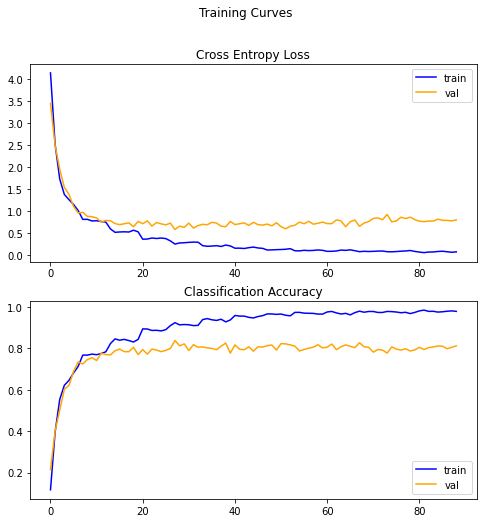


Test set evaluation metrics
30/30 [==============================] - 31s 80ms/step - loss: 0.7517 - accuracy: 0.8089
loss: 0.75
accuracy: 0.81


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.0001)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### learning_rate = $5 * 10^{-4}$

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

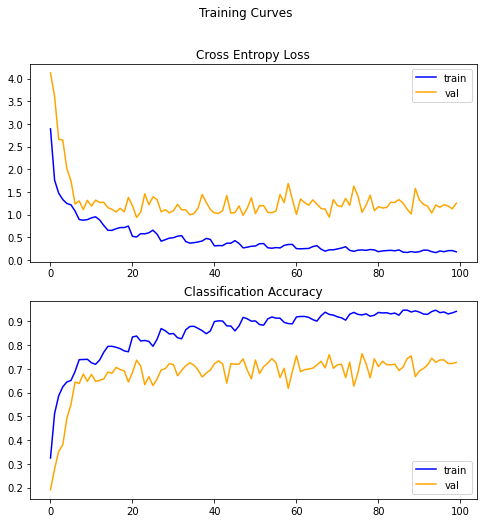


Test set evaluation metrics
30/30 [==============================] - 31s 80ms/step - loss: 1.1757 - accuracy: 0.7227
loss: 1.18
accuracy: 0.72


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.0005)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### learning_rate = $5 * 10^{-3}$

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

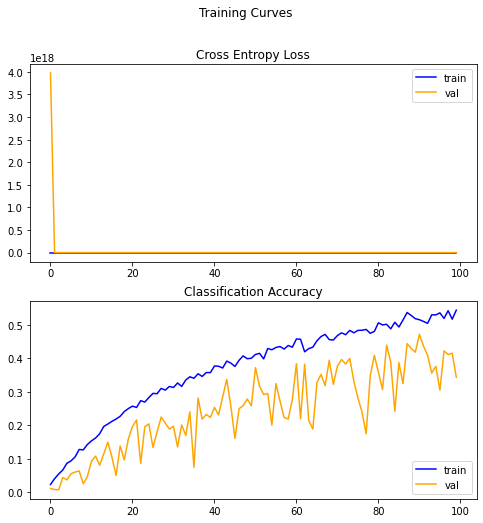


Test set evaluation metrics
30/30 [==============================] - 31s 82ms/step - loss: 2.8243 - accuracy: 0.3451
loss: 2.82
accuracy: 0.35


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.005)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


### Μέγεθος Δέσμης

#### Batch Size = 32

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 78.848 MB

Epoch 1/100
40/40 [==============================] - 

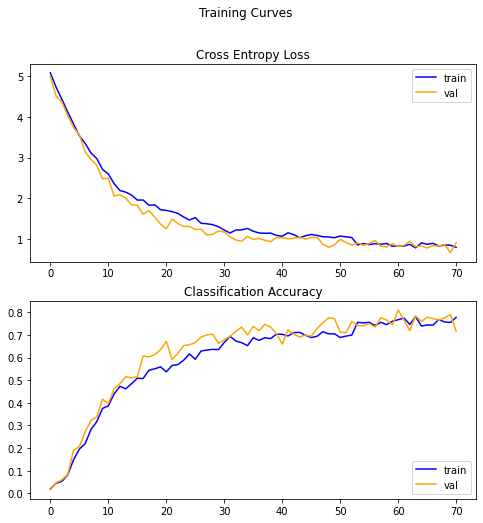


Test set evaluation metrics
30/30 [==============================] - 30s 43ms/step - loss: 0.7235 - accuracy: 0.7927
loss: 0.72
accuracy: 0.79


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### Batch Size = 64

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 86.016 MB

Epoch 1/100
40/40 [==============================] - 

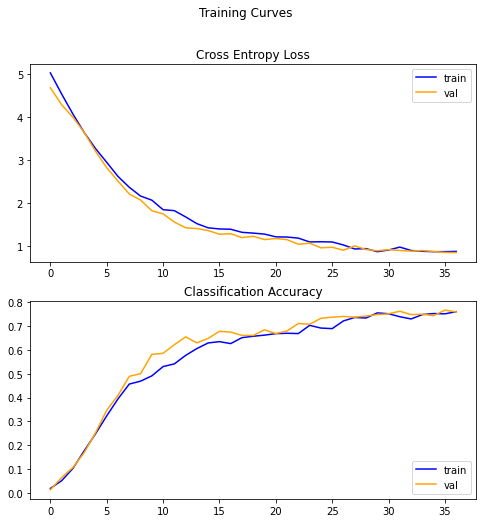


Test set evaluation metrics
30/30 [==============================] - 30s 66ms/step - loss: 0.8444 - accuracy: 0.7536
loss: 0.84
accuracy: 0.75


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


#### Batch Size = 128

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

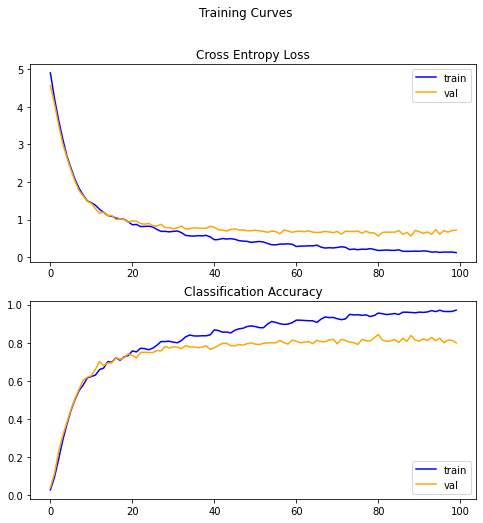


Test set evaluation metrics
30/30 [==============================] - 32s 115ms/step - loss: 0.6164 - accuracy: 0.8281
loss: 0.62
accuracy: 0.83


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


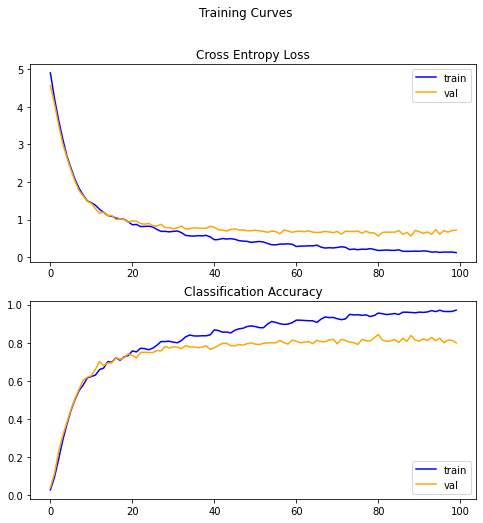


Test set evaluation metrics
30/30 [==============================] - 9s 117ms/step - loss: 0.5721 - accuracy: 0.8385
loss: 0.57
accuracy: 0.84


In [ ]:
model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Batch Size = 256

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 133.12 MB

Epoch 1/100
40/40 [==============================] - 

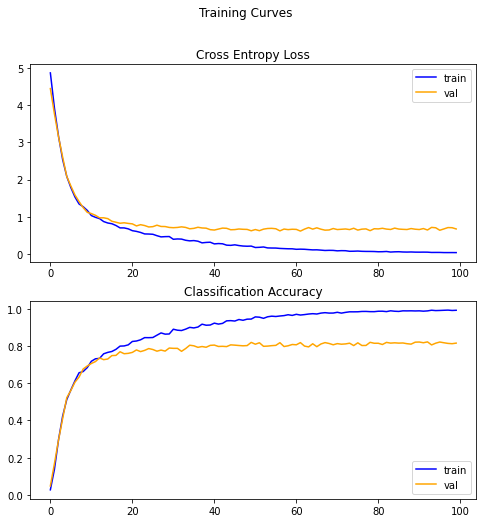


Test set evaluation metrics
30/30 [==============================] - 35s 228ms/step - loss: 0.6394 - accuracy: 0.8378
loss: 0.64
accuracy: 0.84


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


### Optimizer

#### Adam

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

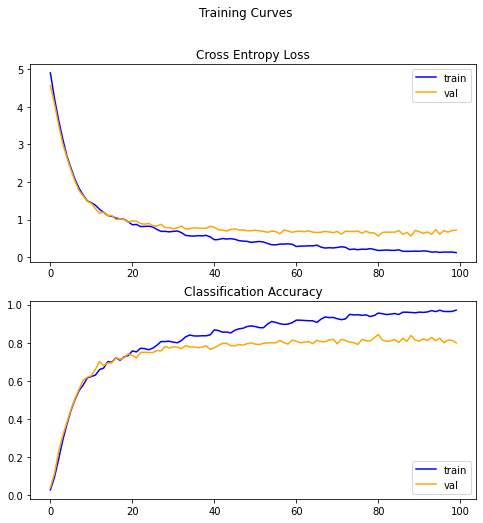


Test set evaluation metrics
30/30 [==============================] - 32s 115ms/step - loss: 0.6164 - accuracy: 0.8281
loss: 0.62
accuracy: 0.83


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)


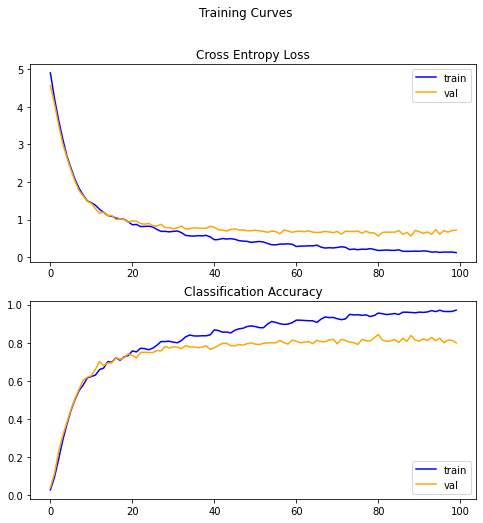


Test set evaluation metrics
30/30 [==============================] - 9s 117ms/step - loss: 0.5721 - accuracy: 0.8385
loss: 0.57
accuracy: 0.84


In [ ]:
model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### Adamax

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 2

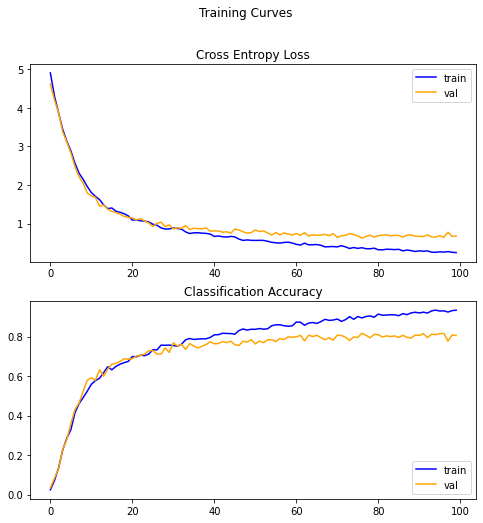


Test set evaluation metrics
30/30 [==============================] - 36s 251ms/step - loss: 0.6344 - accuracy: 0.8188
loss: 0.63
accuracy: 0.82


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025, optimizer="Adamax")
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

#### SGD

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/100
40/40 [==============================] - 1

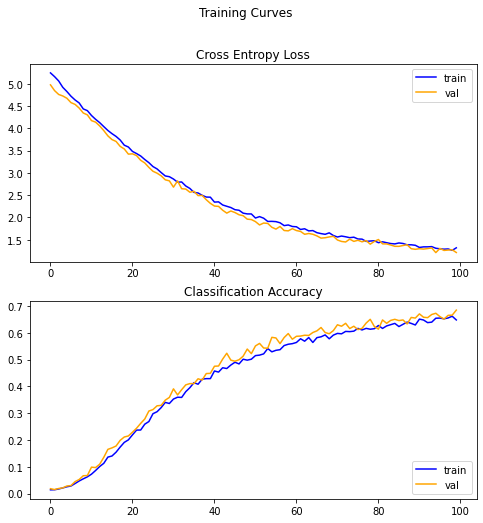


Test set evaluation metrics
30/30 [==============================] - 32s 115ms/step - loss: 1.1754 - accuracy: 0.6820
loss: 1.18
accuracy: 0.68


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, optimizer="SGD")
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

## Παρατηρήσεις ως προς τον αριθμό κλάσεων

### 20 Κλάσεις

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/50
40/40 [==============================] - 40

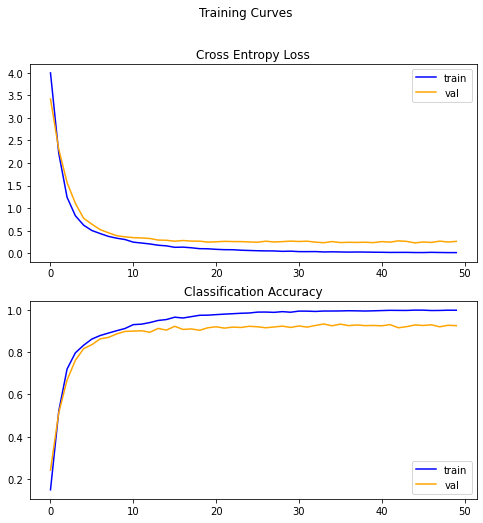


Test set evaluation metrics
30/30 [==============================] - 5s 114ms/step - loss: 0.2890 - accuracy: 0.9219
loss: 0.29
accuracy: 0.92


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 50, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### 40 Κλάσεις

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters: 102.4 MB

Epoch 1/70
40/40 [==============================] - 54

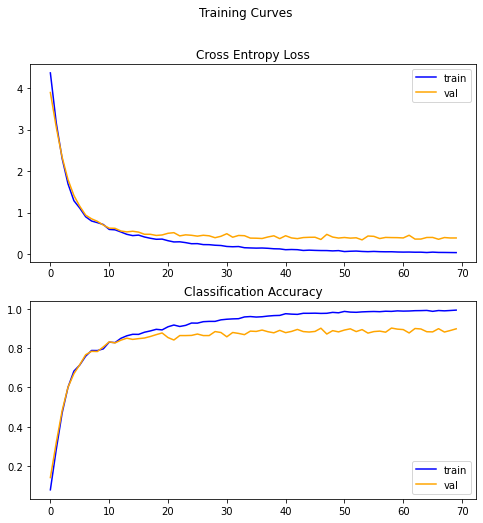


Test set evaluation metrics
30/30 [==============================] - 17s 114ms/step - loss: 0.4095 - accuracy: 0.8828
loss: 0.41
accuracy: 0.88


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 70, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)

### 60 Κλάσεις

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1920)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
Total params: 18,514,084
Trainable params: 18,285,028
Non-trainable params: 229,056
_________________________________________________________________
Memory usage according to parameters:

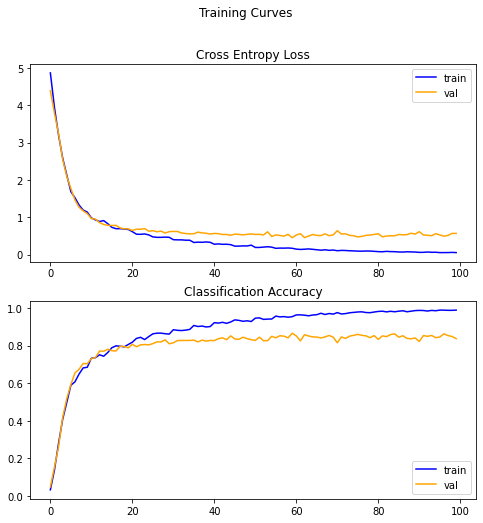


Test set evaluation metrics
30/30 [==============================] - 25s 112ms/step - loss: 0.5003 - accuracy: 0.8565
loss: 0.50
accuracy: 0.86


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

DENSE201_MODEL = init_DENSE201_model(summary = True, inp_size=96, data_augment=True, learning_rate=0.000025)
print("Memory usage according to parameters:",get_model_memory_usage(BATCH_SIZE, DENSE201_MODEL)*1024,"MB")
print("")

start_time = time.time()
DENSE201_MODEL_history = train_model(DENSE201_MODEL, 100, 40, 10, 96,callback)
elapsed_time = time.time() - start_time

print(" ")
print("Time for training the model:",round(elapsed_time,2),"sec")
print(" ")

model_report(DENSE201_MODEL, DENSE201_MODEL_history, 30, 96)